In [26]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('/Users/liyouzhou/study/AR/wk6/pydmps')) # or the path to your source code
sys.path.insert(0, module_path)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pydmps
import pydmps.dmp_discrete
from pathlib import Path

from scipy.io import loadmat
from pathlib import Path
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

figsize = np.array([6.4, 4.8]) / 1.2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:

def getDerivative( positions, time):
    # Calculate derivative using the Five-point stencil method

    rows_num = positions.shape[0]
    dt = time
    sampling_rate = dt
    der = np.zeros(positions.shape)
    for n in range(0, rows_num - 1):
        if n == 0:
            der[n, :] = np.zeros(positions.shape[1])
        elif n == 1 or n == rows_num - 2:
            der[n, :] = (positions[n, :] - positions[n - 1, :]) / dt
        elif 1 < n < rows_num - 2:
            der[n, :] = (
                -positions[n + 2, :]
                + 8 * positions[n + 1, :]
                - 8 * positions[n - 1, :]
                + positions[n - 2, :]
            ) / (12 * dt)
    return der

def import_demonstration(demo_name):
    # Read demonstrations and calculate velocities
    demo = np.loadtxt(demo_name, delimiter=",", dtype=float)
    dt = 0.002
    return demo.T, getDerivative(demo.T, dt)

dataset = []
data_files = ["CShape.csv", "Line.csv", "Sshape.csv", "WShape.csv"]
for f in data_files:
    x_train, dx_train = import_demonstration(Path("datasets") / f)
    dataset.append([x_train, dx_train])

/tmp/ipykernel_9133/3806066517.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("gist_heat")
/tmp/ipykernel_9133/3806066517.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(y_predicted[:, 0], y_predicted[:, 1], "b", lw=2, c = m.to_rgba(n), label=f"n={n}")


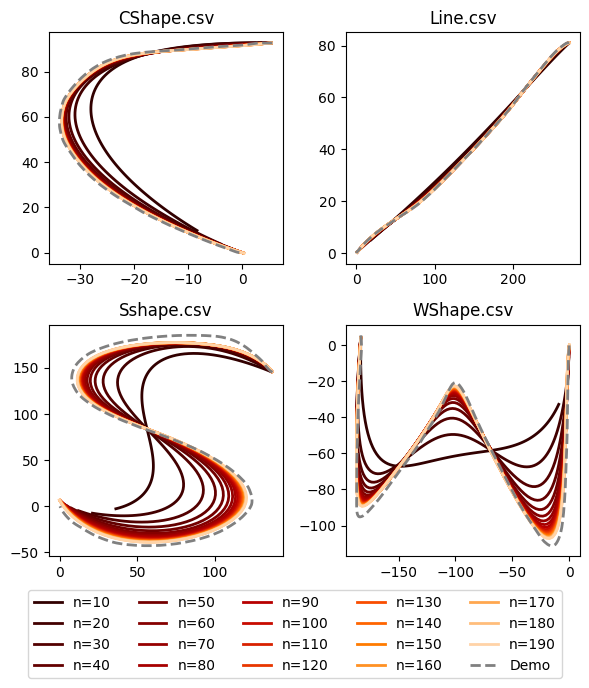

In [28]:
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import time
from collections import defaultdict

fig, axes = plt.subplots(2, 2, figsize=(6,6))
axes = axes.flatten()

n_values = np.arange(10, 200, 10)
norm = mpl.colors.Normalize(
    vmin=min(n_values)- 30, vmax=max(n_values) + 20
)
cmap = cm.get_cmap("gist_heat")
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# colors = sns.color_palette("husl", len(n_values) + 1)
accuracy = defaultdict(list)
dts = defaultdict(list)
dmp_distances = defaultdict(list)
for data,l, ax in zip(dataset, data_files, axes):
    # Load a demonstration trajectory as numpy array from the examples folder
    y_des, _ = data
    y_des = y_des.T

    for n in n_values:
        # Create the DMP object and set number of DMPs, RBFs and Starting state
        dmp = pydmps.dmp_discrete.DMPs_discrete(n_dmps=2, n_bfs=n, y0=y_des[:, 0])

        # Train the weights of the DMPs using the imitate path method
        t1 = time.time()
        f_demo = dmp.imitate_path(y_des=y_des, plot=False)
        y_predicted, dy_predicted, ddy_predicted, f_learn = dmp.rollout()
        dt = (time.time() - t1) * 1000
        # print(f"Training time for {n} basis functions: {dt:.03}ms")
        mse = ((f_demo - f_learn)**2).mean()
        # print(f"Mean squared error: {mse:.03}")

        accuracy[l].append(mse)
        dts[l].append(dt)
        d, _ = fastdtw(y_predicted, y_des.T, dist=euclidean)
        dmp_distances[l].append(d)

        ax.plot(y_predicted[:, 0], y_predicted[:, 1], "b", lw=2, c = m.to_rgba(n), label=f"n={n}")

    ax.plot(y_des[0, :], y_des[1, :], "--", c="gray", ms=1, label="Demo", lw=2)
    ax.set_title(l)
    # ax.legend()

h, l = ax.get_legend_handles_labels()
plt.figlegend(h, l, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.15))
plt.tight_layout()
plt.savefig("../report/figures/dmp_imitation.png", bbox_inches='tight')

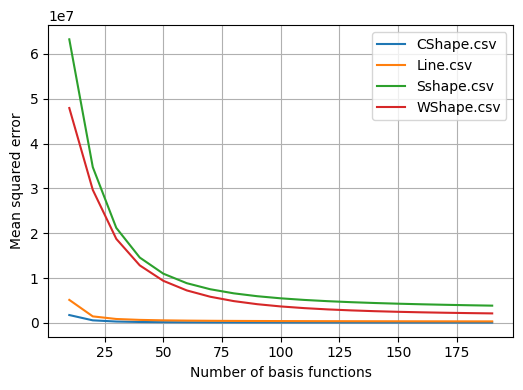

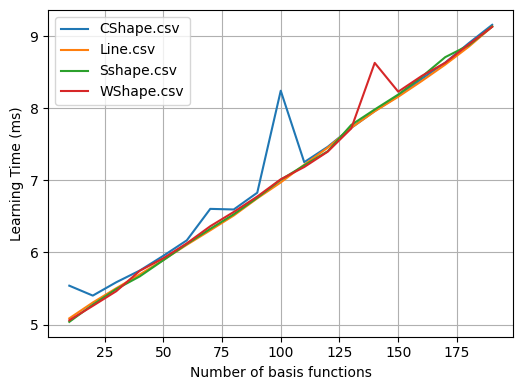

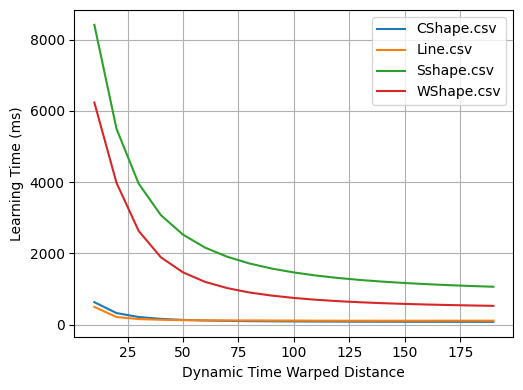

In [29]:
plt.figure(figsize = figsize)
for k, v in accuracy.items():
    plt.plot(n_values, v, label=k)
    plt.xlabel("Number of basis functions")
    plt.ylabel("Mean squared error")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../report/figures/dmp_imitation_mse.png", bbox_inches='tight')

plt.figure(figsize = figsize)
for k, v in dts.items():
    plt.plot(n_values, v, label=k)
    plt.xlabel("Number of basis functions")
    plt.ylabel("Learning Time (ms)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../report/figures/dmp_imitation_dt.png", bbox_inches='tight')

plt.figure(figsize = figsize)
for k, v in dmp_distances.items():
    plt.plot(n_values, v, label=k)
    plt.xlabel("Dynamic Time Warped Distance")
    plt.ylabel("Learning Time (ms)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("../report/figures/dmp_imitation_distances.png", bbox_inches='tight')


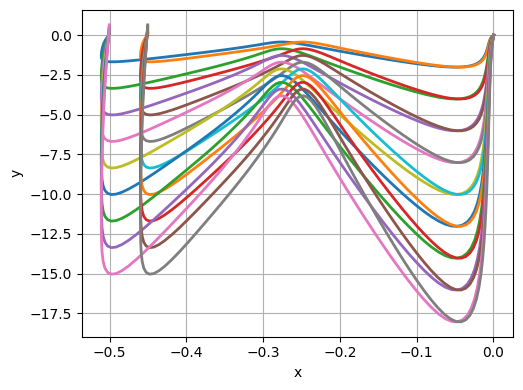

In [30]:
plt.figure(1, figsize=figsize)

for y0 in np.arange(0.1, 1.0, 0.1):
    for x0 in np.arange(-.5, -0.4, 0.05):
        dmp.y0 = np.array([x0, y0])

        # generate a trajectory from the trained DMP using the rollout method
        y_predicted, dy_predicted, ddy_predicted, f_learn = dmp.rollout()

        # Use Matplotlib to generate the desired plots
        plt.plot(y_predicted[:, 0], y_predicted[:, 1], lw=2)

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.tight_layout()
plt.savefig("../report/figures/vary_init_dmp_rollout.png", bbox_inches='tight')


In [31]:
fns = Path("logs").glob("*.mat")
fns = sorted(fns, key=lambda x: int(Path(x).stem.split("_")[1]))
seds_distances = defaultdict(list)
seds_times = defaultdict(list)
distances = []
for fn in fns:
    # print(fn)
    data = loadmat(fn)
    data_fn = Path(fn).stem.split("_")[0]
    ns = int(Path(fn).stem.split("_")[1])

    demo = np.loadtxt(f"datasets/{data_fn}.csv", delimiter=",", dtype=float)

    # print(data["x"].shape, demo.shape)
    distance, path = fastdtw(data["x"].T, demo.T, dist=euclidean)
    distances.append([distance, ns, data, data_fn, ns, demo])
    seds_distances[data_fn].append(distance)
    seds_times[data_fn].append(data["elapsedTime"])

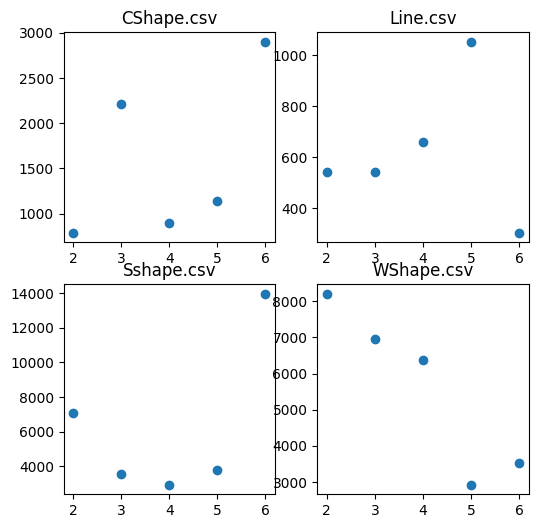

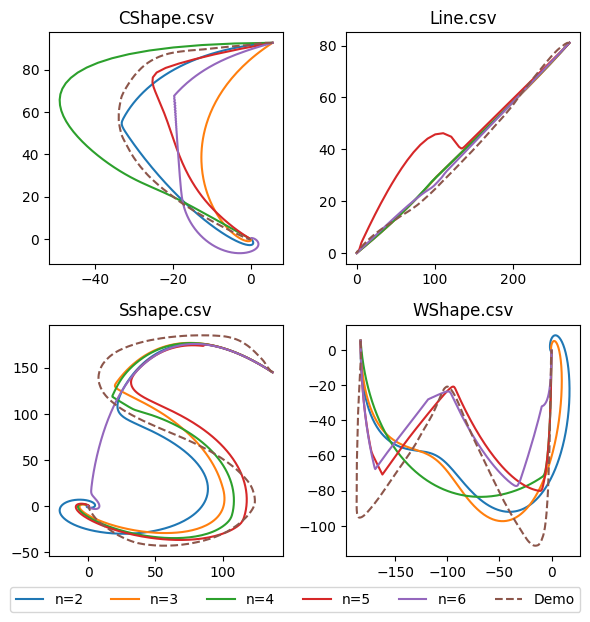

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))
fig2, axes2 = plt.subplots(2, 2, figsize=(6,6))
axes = axes.flatten()
axes2 = axes2.flatten()
for l, ax, ax2 in zip(data_files, axes, axes2):
    demo_name = l.split(".")[0]
    d = [x for x in distances if x[3] == demo_name]
    traj = [x[2]["x"] for x in d]
    ns = [x[4] for x in d]
    dist = [x[0] for x in d]

    ax2.plot(ns,dist,  "o")
    ax2.set_title(l)

    for t, n in zip(traj, ns):
        ax.plot(t[0,:], t[1,:], "-", label=f"n={n}")

    demo = np.loadtxt(f"datasets/{demo_name}.csv", delimiter=",", dtype=float)
    ax.plot(demo[0,:], demo[1,:], "--", label="Demo")

    ax.set_title(l)

h, l = ax.get_legend_handles_labels()
plt.figure(fig)
plt.figlegend(h, l, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.04))
plt.tight_layout()
plt.savefig("../report/figures/seds_imitation.png", bbox_inches='tight')


CShape.csv
Line.csv
Sshape.csv
WShape.csv


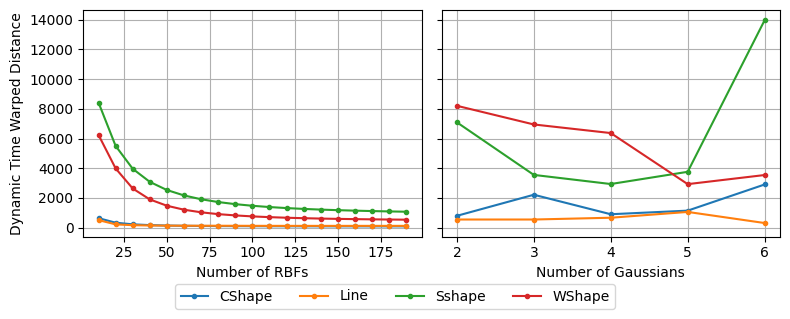

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
axes = axes.flatten()

demo_name = "CShape"
d = [x for x in distances if x[3] == demo_name]
ns = [x[4] for x in d]

for data_file in data_files:
    print(data_file)

    k = data_file.split(".")[0]
    v = seds_distances[k]
    axes[1].plot(ns,v, ".-",label=k)

    v = dmp_distances[data_file]
    axes[0].plot(n_values, v, ".-", label=k)

for ax in axes:
    ax.grid()

axes[0].set_ylabel("Dynamic Time Warped Distance")
axes[0].set_xlabel("Number of RBFs")
axes[1].set_xlabel("Number of Gaussians")
# axes[0].set_title("DMP")
# axes[1].set_title("SEDS")

h, l = ax.get_legend_handles_labels()
plt.figlegend(h, l, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.07))
plt.tight_layout()
plt.savefig("../report/figures/dmp_seds_distances_comparison.png", bbox_inches='tight')


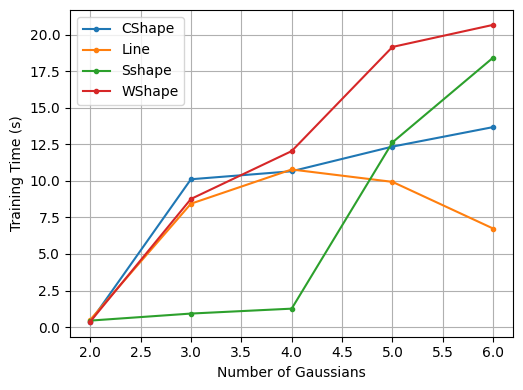

In [34]:
demo_name = "CShape"
d = [x for x in distances if x[3] == demo_name]
ns = [x[4] for x in d]

plt.figure(figsize = figsize)
for data_file in data_files:
    k = data_file.split(".")[0]
    v = [x[0][0] for x in seds_times[k]]

    plt.plot(ns,v, ".-", label=k)

plt.legend()
plt.grid()
plt.ylabel("Training Time (s)")
plt.xlabel("Number of Gaussians")
plt.tight_layout()
plt.savefig("../report/figures/seds_training_time.png", bbox_inches='tight')
